# Importing the Libraries

In [1]:
import pandas as pd #pandas library for data loading and manipulation
import numpy as np # numpy library for data computation
import seaborn as sns #seaborn library for data visualization
import matplotlib.pyplot as plt # %matplotliblotlibotlib for data visualization

# Data Loading

In [2]:
#loading the data printing the shape and head
data=pd.read_csv("loan.csv")
print(data.shape)
data.head(1)

(39717, 111)


/home/rishabh/py3_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


****we will be doing the analysis only where the loan status is either fully paid or charged off since where the loan status is current we are not sure whether the loan will be sucessful in that case or it will be defaulted so we will not do analysis for those cases****

In [3]:
data=data[(data["loan_status"]=="Fully Paid") | (data["loan_status"]=="Charged Off")]

# Data Checks

#### checking and dropping the rows which are completly duplicates

In [4]:
print(data.duplicated().sum())
data.drop_duplicates(inplace=True)

0


#### Removing the columns which has more than 50% null values

In [5]:
columns_which_are_to_be_removed=(list(data.columns[data.isnull().mean() > 0.5]))
data.drop(columns=columns_which_are_to_be_removed,axis=1,inplace=True)

#### converting the data types of columns which are incorrect

In [6]:
data["revol_util"]=data["revol_util"].apply(lambda x: float(str(x).replace("%","")))

In [7]:
data["int_rate"]=data["int_rate"].apply(lambda x: float(x.replace("%","")))

In [8]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 54 columns):
id                            38577 non-null int64
member_id                     38577 non-null int64
loan_amnt                     38577 non-null int64
funded_amnt                   38577 non-null int64
funded_amnt_inv               38577 non-null float64
term                          38577 non-null object
int_rate                      38577 non-null float64
installment                   38577 non-null float64
grade                         38577 non-null object
sub_grade                     38577 non-null object
emp_title                     36191 non-null object
emp_length                    37544 non-null object
home_ownership                38577 non-null object
annual_inc                    38577 non-null float64
verification_status           38577 non-null object
issue_d                       38577 non-null object
loan_status                   38577 non-null object
pymnt_p

***From data info it is clear that almost all columns except one column which is desc, have a very high non null values since this desc is a loan description provided by the borrower which is string since we are not building any NLP sort of model we can drop this columns since it will not help in our analysis and also the unique values are also very high for object type columns which will not add anything to our analysis***

In [9]:
print(data["desc"].nunique())
data.drop(columns=["desc"],inplace=True)

25803


****Dropping all those columns which have single unique value such columns will not add anything to our analysis****

In [10]:
columns_to_be_dropped=["tax_liens","delinq_amnt","chargeoff_within_12_mths","acc_now_delinq","application_type","policy_code","collections_12_mths_ex_med","initial_list_status","pymnt_plan"]

In [11]:
data.drop(columns=columns_to_be_dropped,inplace=True)

****Dropping all those columns which are not useful for analysis on the basis of general understanding and thru domain knowledge****


In [12]:
drop_columns=["id","member_id","last_pymnt_d","last_pymnt_amnt","zip_code","title","url","emp_title","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","collection_recovery_fee","revol_bal","recoveries","out_prncp","out_prncp_inv"]
data.drop(columns=drop_columns,inplace=True)

In [13]:
data.shape

(38577, 26)

## Missing Value imputation

****The pub_rec_bankruptcies has three values 0 ,1 and 2 so the maximum is occurence is 0 so we are replacing missing values with 0****

In [14]:
mode=(data["pub_rec_bankruptcies"]).mode()[0]
data["pub_rec_bankruptcies"].fillna(value=mode,inplace=True)

****Emp length is categorical values with 10 -12 different values so replacing the missing value with mode****

In [15]:
mode_emp_len=data["emp_length"].mode()[0]
data["emp_length"].fillna(value=mode_emp_len,inplace=True)

****revol_util has values which is replaced by the mean of that column****

In [16]:
mean=data["revol_util"].mean()
data["revol_util"].fillna(value=mean,inplace=True)

****last_credit_pull_d is date value column so we are imputing the missing value with most occuring date****

In [17]:
last_credit_pull_d_mode=data["last_credit_pull_d"].mode()[0]
data["last_credit_pull_d"].fillna(value=last_credit_pull_d_mode,inplace=True)

****finding the correlation between numerical variables****

In [18]:
data.corr()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.981790,0.937922,0.301265,0.932260,0.268999,0.062436,-0.031951,0.012940,0.177200,-0.049997,0.063447,0.256179,-0.035141
funded_amnt,0.981790,1.000000,0.956172,0.304930,0.958035,0.264798,0.062194,-0.031866,0.012857,0.175682,-0.050576,0.067312,0.250551,-0.036189
funded_amnt_inv,0.937922,0.956172,1.000000,0.297473,0.905464,0.251981,0.070663,-0.038171,-0.002800,0.162738,-0.051470,0.072154,0.242715,-0.036327
int_rate,0.301265,0.304930,0.297473,1.000000,0.277203,0.048899,0.110913,0.158479,0.133362,0.006022,0.098635,0.466762,-0.046539,0.084016
installment,0.932260,0.958035,0.905464,0.277203,1.000000,0.267842,0.052038,-0.019755,0.011014,0.172893,-0.045706,0.092994,0.229860,-0.033038
annual_inc,0.268999,0.264798,0.251981,0.048899,0.267842,1.000000,-0.121530,0.022229,0.035465,0.156927,-0.017864,0.016696,0.234534,-0.015955
dti,0.062436,0.062194,0.070663,0.110913,0.052038,-0.121530,1.000000,-0.033347,0.002178,0.287849,-0.004742,0.278692,0.229119,0.007315
delinq_2yrs,-0.031951,-0.031866,-0.038171,0.158479,-0.019755,0.022229,-0.033347,1.000000,0.008733,0.011649,0.007623,-0.042568,0.066994,0.002970
inq_last_6mths,0.012940,0.012857,-0.002800,0.133362,0.011014,0.035465,0.002178,0.008733,1.000000,0.093434,0.023726,-0.070174,0.113516,0.014821
open_acc,0.177200,0.175682,0.162738,0.006022,0.172893,0.156927,0.287849,0.011649,0.093434,1.000000,0.000028,-0.089835,0.687260,0.005616


****removing columns based on correlation analysis****

In [19]:
# Loan amount ,funded_amnt and funded_amnt_inv these three columns are highly correlated and also when someone applies for loan we have loan amount information so will keep this and drop the other two
col_to_drop=["funded_amnt","funded_amnt_inv"]
data.drop(columns=col_to_drop,inplace=True)

In [20]:
#issue_d,earliest_cr_line,last_credit_pull_d these 3 dates doesn't seem to be important from domain knowledge
col_to_drop=["issue_d","earliest_cr_line","last_credit_pull_d"]
data.drop(columns=col_to_drop,inplace=True)

## High level analysis

In [21]:
# bucketing the columns into 2 bucket based upon thier values numerical and categorical values
Numerical_cols=["loan_amnt","int_rate","installment","annual_inc","dti","revol_util"]
categorical_cols=["term","grade","sub_grade","emp_length","home_ownership","verification_status","loan_status","purpose","addr_state","pub_rec_bankruptcies","delinq_2yrs","inq_last_6mths","open_acc","pub_rec","total_acc"]

****Using Value counts function to analyze the distribution of categorical columns****

In [23]:
col=list(data.columns)
for i in categorical_cols:
    print("\n"*2)
    print(i)
    print(data[i].value_counts())




term
 36 months    29096
 60 months     9481
Name: term, dtype: int64



grade
B    11675
A    10045
C     7834
D     5085
E     2663
F      976
G      299
Name: grade, dtype: int64



sub_grade
A4    2873
B3    2825
A5    2715
B5    2615
B4    2437
C1    2055
B2    2001
C2    1931
A3    1810
B1    1797
A2    1508
C3    1488
D2    1286
C4    1206
C5    1154
A1    1139
D3    1116
D1     931
D4     918
D5     834
E1     722
E2     614
E3     516
E4     424
E5     387
F1     305
F2     233
F3     174
F4     151
F5     113
G1      94
G2      77
G4      54
G3      45
G5      29
Name: sub_grade, dtype: int64



emp_length
10+ years    9521
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64



home_ownership
RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: home_ownership, dtype: int64



****Using the describe function to get some more understanding of numerical columns****

In [24]:
for i in Numerical_cols:
    print("\n"*2)
    print(i)
    print(data[i].describe())




loan_amnt
count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64



int_rate
count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64



installment
count    38577.000000
mean       322.466318
std        208.639215
min         15.690000
25%        165.740000
50%        277.860000
75%        425.550000
max       1305.190000
Name: installment, dtype: float64



annual_inc
count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64



dti
count    38577.000000
mean        13.272727
std          6.673044
min          0.000000
25%          8.13

## Outliers treatment

In [25]:
def outlier_analysis(column_name):
    print(data[column_name].describe())
    data[column_name].plot.box()
    plt.show()
    

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


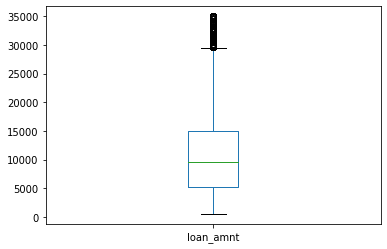

In [26]:
''''from the below graph and describe summary it is clear that good percentage of data points lies in outliers region that 
is above 1.5*IQR +(75 percentile) so we don't do any treatment for loan amount'''
outlier_analysis('loan_amnt')

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64


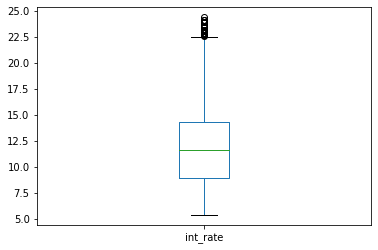

65


In [27]:
'''There are 65 values which lies in outliers region since these value can ge genuine values so we can't drop them 
but what we can do is we can cap all values which are more than 22.5 at 22.5 '''
outlier_analysis('int_rate')
print(len(data[data['int_rate']>22.5]))

In [28]:
data['int_rate'].mask(data['int_rate']>22.5, 22.5, inplace=True)

count    38577.000000
mean       322.466318
std        208.639215
min         15.690000
25%        165.740000
50%        277.860000
75%        425.550000
max       1305.190000
Name: installment, dtype: float64


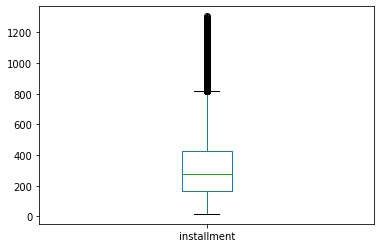

'There is good number of datapoints lying in the outlier region so will not handle these outliers for installment'

In [29]:
outlier_analysis('installment')
'''There is good number of datapoints lying in the outlier region so will not handle these outliers for installment'''

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64


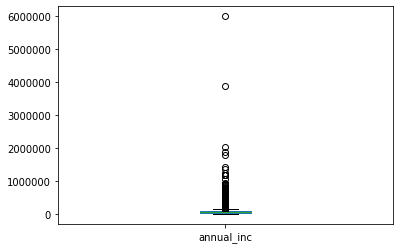

In [30]:
''' There are so many outliers in income so we have to handle them 99th percentile is on 234143 value so will drop 
all values which are above 250000 they are extrame outliers'''
outlier_analysis('annual_inc')

In [31]:
data.drop(data[data["annual_inc"]>250000].index,inplace=True)

count    38284.000000
mean        13.323463
std          6.658527
min          0.000000
25%          8.200000
50%         13.420000
75%         18.590000
max         29.990000
Name: dti, dtype: float64


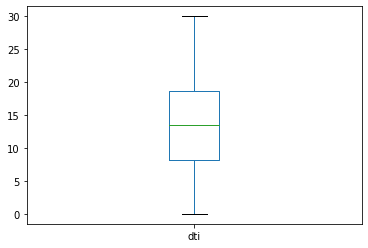

In [32]:
'''There are no outliers so need to treatment require for dti'''
outlier_analysis('dti')

count    38284.000000
mean        48.697717
std         28.325101
min          0.000000
25%         25.275000
50%         49.000000
75%         72.200000
max         99.900000
Name: revol_util, dtype: float64


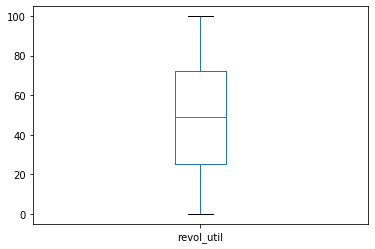

In [33]:
'''There are no outliers so need to treatment require for revol_util'''
outlier_analysis('revol_util')

****Analyzing the distribution of numerical cols using histogram****




loan_amnt


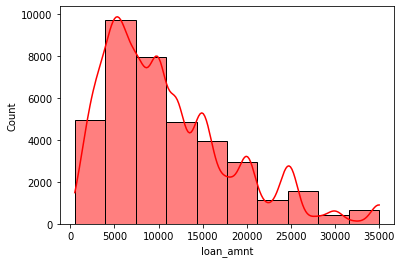




int_rate


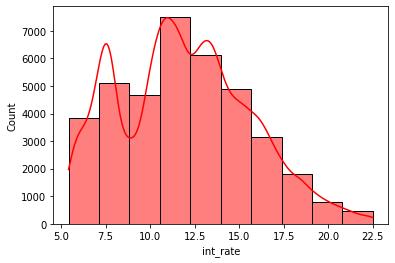




installment


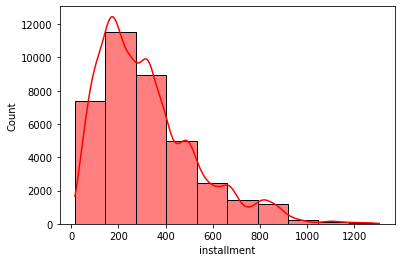




annual_inc


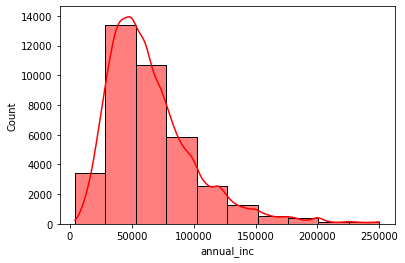




dti


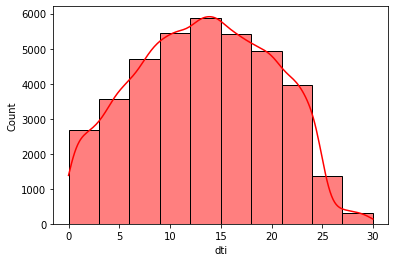




revol_util


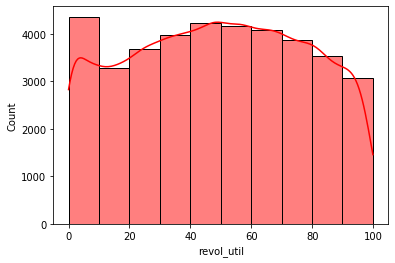

In [34]:
for i in Numerical_cols:
    print("\n"*2)
    print(i)
    sns.histplot(data = data[i], kde = True,bins=10,color='red')
    plt.show()

****Analyzing the categorical cols using count plot****

In [35]:
def plot_countplot(col):
    sns.countplot(x =col, data = data)
    plt.show()

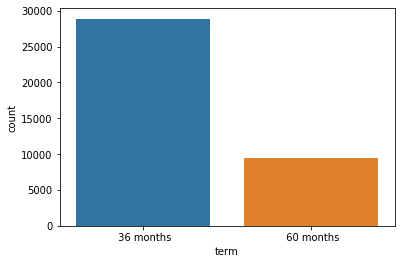

In [36]:
plot_countplot("term")
#so there are two category of term and both occur in significant number

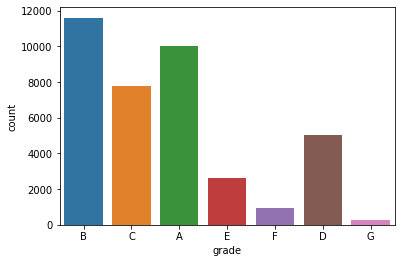

In [37]:
plot_countplot("grade")
#grade G and F occure in less in numbers

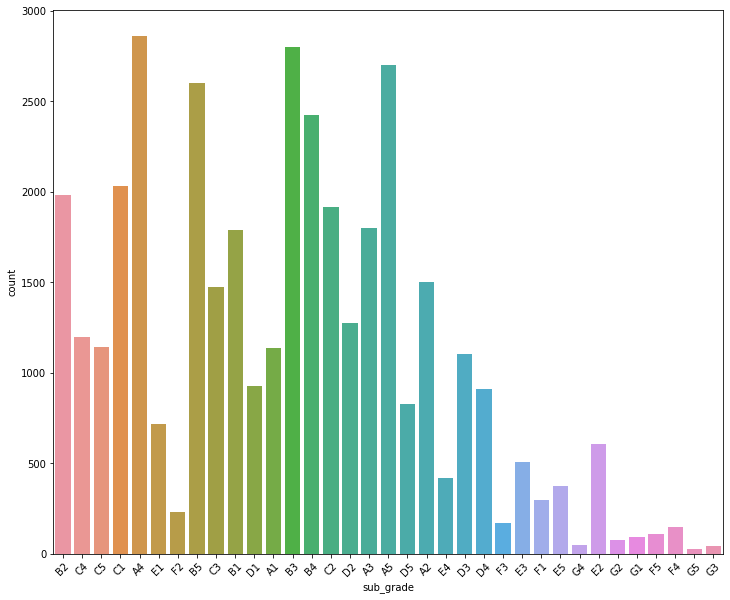

In [38]:
plt.figure(figsize=(12,10))
sns.countplot(x ="sub_grade", data = data)
plt.xticks(rotation=45)
plt.show()

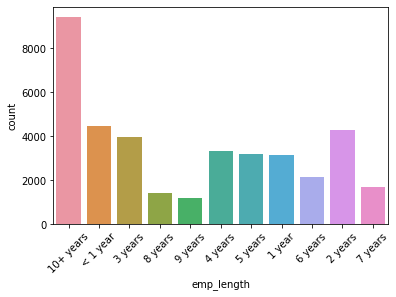

In [39]:
sns.countplot(x ="emp_length", data = data)
plt.xticks(rotation=45)
plt.show()
# All category are significant in number

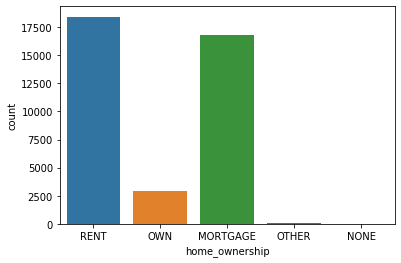

In [40]:
plot_countplot("home_ownership")
#THE OTHER AND NONE CATEGORY ARE IN MINORITY IN NUMBER WHICH ARE 97 AND 3 RESPECTIVLY 

In [41]:
data.drop(data[data["home_ownership"]=="NONE"].index,inplace=True)

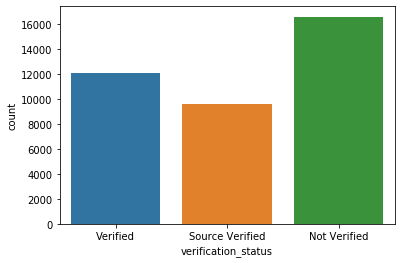

In [42]:
plot_countplot("verification_status")
#ALL THREE CATEGORY ARE IN SIGNIFICANT IN NUMBERS

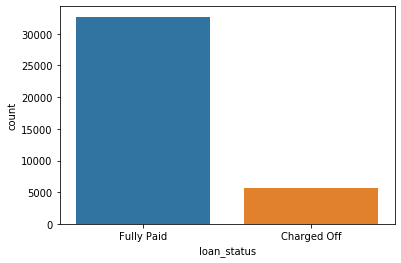

In [43]:
plot_countplot("loan_status")
# LOAN DEFAULTED ARE LESS IN NUMBER COMPARE TO LOAN PAID WHICH IS CONSISTENT WITH THE GENERAL TREND

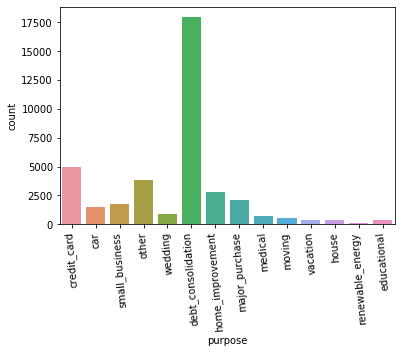

In [44]:
sns.countplot(x ="purpose", data = data)
plt.xticks(rotation=95)
plt.show()
# All category are COMPARABLE in number

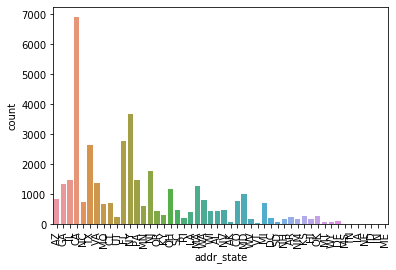

In [45]:
sns.countplot(x ="addr_state", data = data)
plt.xticks(rotation=90)
plt.show()
# All category are COMPARABLE in number

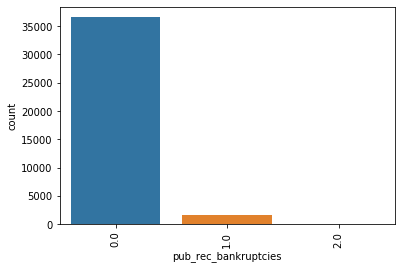

In [46]:
sns.countplot(x ="pub_rec_bankruptcies", data = data)
plt.xticks(rotation=90)
plt.show()
# pub_rec_bankruptcies category 2.0 is too less only 5 datapoints

In [47]:
data.drop(data[data["pub_rec_bankruptcies"]==2.0].index,inplace=True)

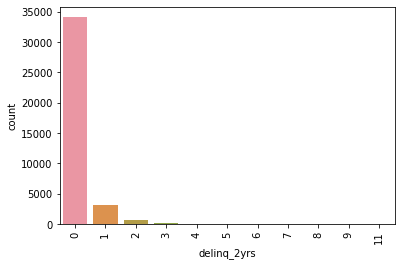

In [48]:
sns.countplot(x ="delinq_2yrs", data = data)
plt.xticks(rotation=90)
plt.show()
#except category 0 ,1,2,3 all are very insignificant in number

In [49]:
data.drop(data[data["delinq_2yrs"]==4.0].index,inplace=True)
data.drop(data[data["delinq_2yrs"]==5.0].index,inplace=True)
data.drop(data[data["delinq_2yrs"]==6.0].index,inplace=True)
data.drop(data[data["delinq_2yrs"]==7.0].index,inplace=True)
data.drop(data[data["delinq_2yrs"]==8.0].index,inplace=True)
data.drop(data[data["delinq_2yrs"]==9.0].index,inplace=True)
data.drop(data[data["delinq_2yrs"]==11.0].index,inplace=True)

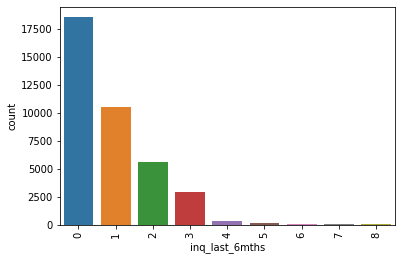

In [50]:
sns.countplot(x ="inq_last_6mths", data = data)
plt.xticks(rotation=90)
plt.show()
# all are in comparable numbers

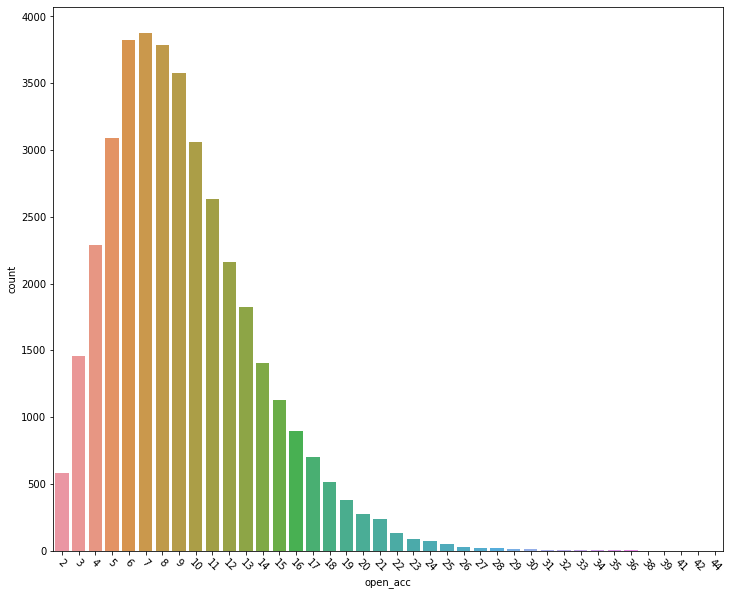

In [51]:
plt.figure(figsize=(12,10))
sns.countplot(x ="open_acc", data = data)
plt.xticks(rotation=-45)
plt.show()
# all are in comparable numbers

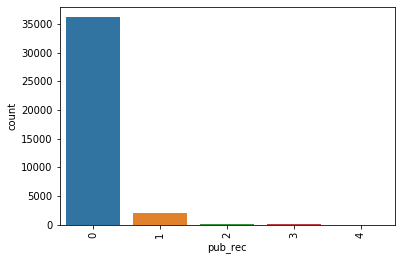

In [52]:
sns.countplot(x ="pub_rec", data = data)
plt.xticks(rotation=90)
plt.show()

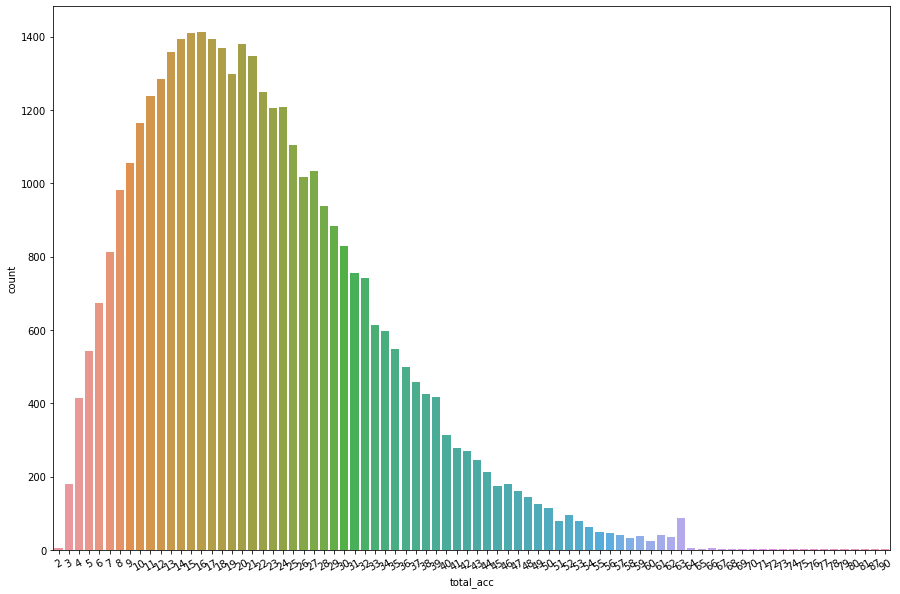

In [53]:
plt.figure(figsize=(15,10))
sns.countplot(x ="total_acc", data = data)
plt.xticks(rotation=30)
plt.show()

### creating bins for Numerical cols

In [54]:
data["int_rate"].min()# the min value of interest rate

5.42

In [55]:
data['int_rate_groups'] = pd.cut(data['int_rate'], bins=4,precision =0,labels=['low_int_rate','moderate_int_rate','high_int_rate','very high_int_rate'])
data['loan_amnt_groups'] = pd.cut(data['loan_amnt'], bins=4,precision =0,labels=['low_loan_amnt','moderate_loan_amnt','high_loan_amnt','very high_loan_amnt'])
data['installment_groups'] = pd.cut(data['installment'], bins=4,precision =0,labels=['low_installment','moderate_installment','high_installment','very high_installment'])
data['annual_inc_groups'] = pd.cut(data['annual_inc'], bins=4,precision =0,labels=['low_annual_inc','moderate_annual_inc','high_annual_inc','very high_annual_inc'])
data['dti_groups'] = pd.cut(data['dti'], bins=4,precision =0,labels=['low_dti','moderate_dti','high_dti','very high_dti'])
data['revol_util_groups'] = pd.cut(data['revol_util'], bins=4,precision =0,labels=['low_revol_util','moderate_revol_util','high_revol_util','very high_revol_util'])


### Graphical Analysis wrt loan status against the column for which binning is done

In [56]:
def plot_function_against_loan_status(column_name):
    fig, ax = plt.subplots(figsize = (15,10))
    plt.subplot(221)
    sns.countplot(x=column_name, data=data[data.loan_status == 'Fully Paid'])
    plt.title("Fully Paid")
    plt.xlabel(column_name)
    plt.subplot(222)
    sns.countplot(x=column_name, data=data[data.loan_status == 'Charged Off'])
    plt.title("Charged Off")
    plt.show()

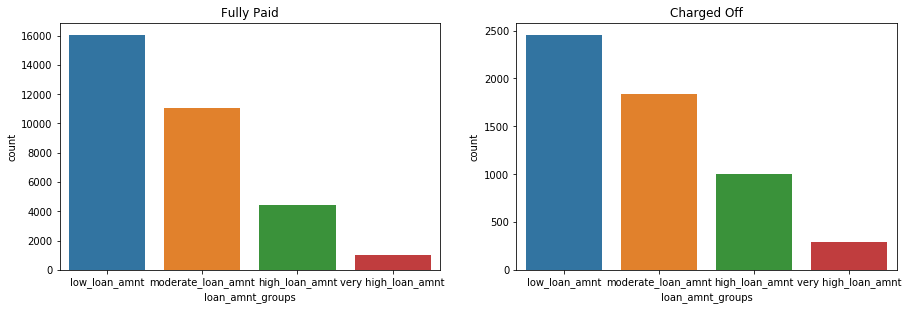

The ratio of default in different category of loan amount are
low_loan_amnt          0.152951
moderate_loan_amnt     0.165388
high_loan_amnt         0.223616
very high_loan_amnt    0.289023
Name: loan_amnt_groups, dtype: float64


In [57]:
#loan_amnt
plot_function_against_loan_status(column_name="loan_amnt_groups")
print("The ratio of default in different category of loan amount are")
print(data[data["loan_status"]=="Charged Off"]["loan_amnt_groups"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["loan_amnt_groups"].value_counts()))
#There are high chance of default when the loan amount is high

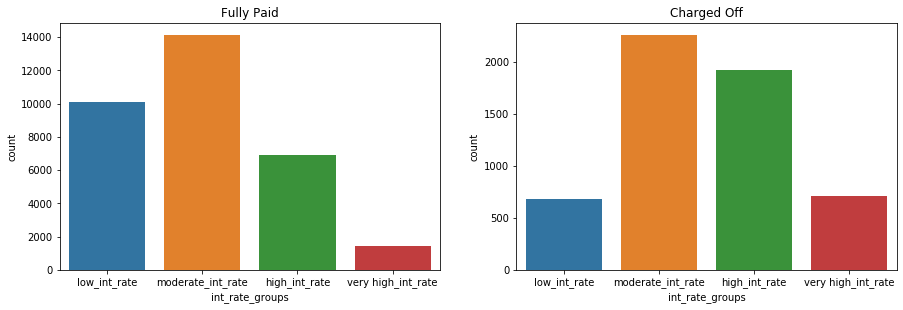

The ratio of default in different category of int rate are
low_int_rate          0.067320
moderate_int_rate     0.159762
high_int_rate         0.277698
very high_int_rate    0.498596
Name: int_rate_groups, dtype: float64


In [58]:
plot_function_against_loan_status(column_name="int_rate_groups")
print("The ratio of default in different category of int rate are")
print(data[data["loan_status"]=="Charged Off"]["int_rate_groups"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["int_rate_groups"].value_counts()))
#if the interest is high there is high chances of default 

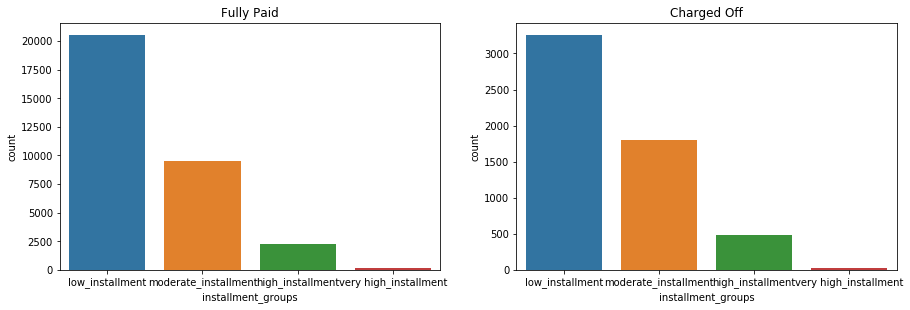

The ratio of default in different category of installment_groups are
low_installment          0.158653
moderate_installment     0.188824
high_installment         0.211438
very high_installment    0.124402
Name: installment_groups, dtype: float64


In [59]:
plot_function_against_loan_status(column_name="installment_groups")
print("The ratio of default in different category of installment_groups are")
print(data[data["loan_status"]=="Charged Off"]["installment_groups"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["installment_groups"].value_counts()))
#The deafult chance are high when the installments are high or very high 

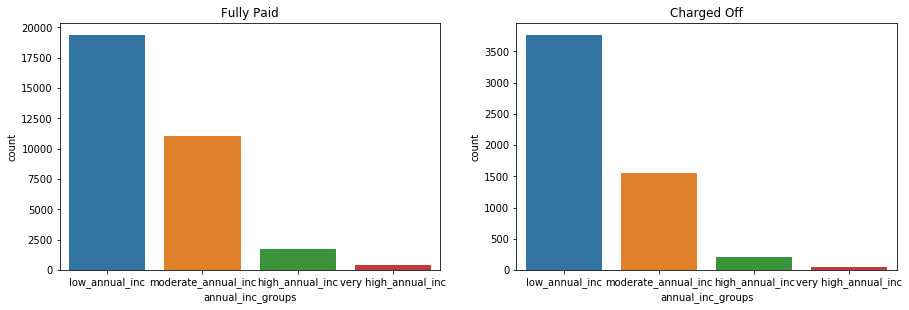

The ratio of default in different category of annual_inc_groups are
low_annual_inc          0.194369
moderate_annual_inc     0.139760
high_annual_inc         0.123615
very high_annual_inc    0.109813
Name: annual_inc_groups, dtype: float64


In [60]:
plot_function_against_loan_status(column_name="annual_inc_groups")
print("The ratio of default in different category of annual_inc_groups are")
print(data[data["loan_status"]=="Charged Off"]["annual_inc_groups"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["annual_inc_groups"].value_counts()))
# low income are moderate income group are more prone to default

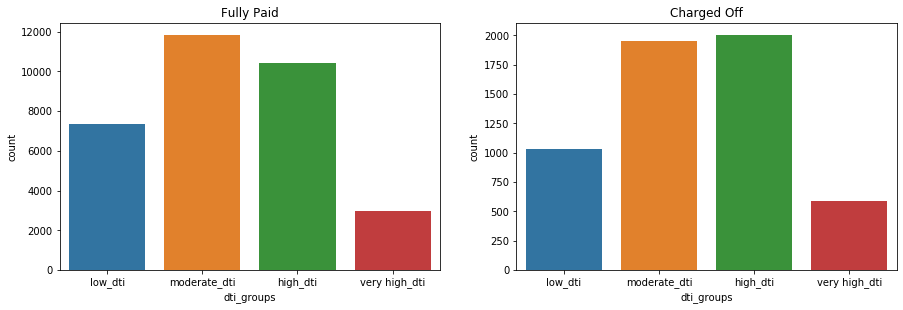

The ratio of default in different category of dti_groups are
low_dti          0.139810
moderate_dti     0.165077
high_dti         0.192441
very high_dti    0.196633
Name: dti_groups, dtype: float64


In [61]:
plot_function_against_loan_status(column_name="dti_groups")
print("The ratio of default in different category of dti_groups are")
print(data[data["loan_status"]=="Charged Off"]["dti_groups"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["dti_groups"].value_counts()))
# high and very high dti group have high chance of default 

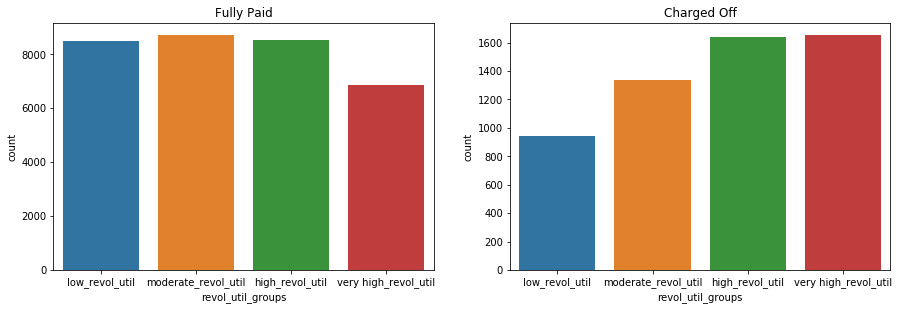

The ratio of default in different category of revol_util_groups are
low_revol_util          0.111059
moderate_revol_util     0.152876
high_revol_util         0.192321
very high_revol_util    0.241681
Name: revol_util_groups, dtype: float64


In [62]:
plot_function_against_loan_status(column_name="revol_util_groups")
print("The ratio of default in different category of revol_util_groups are")
print(data[data["loan_status"]=="Charged Off"]["revol_util_groups"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["revol_util_groups"].value_counts()))
# high and very high revol_util_groups have high chance of default 

## Analysis of categorical  variables wrt loan status

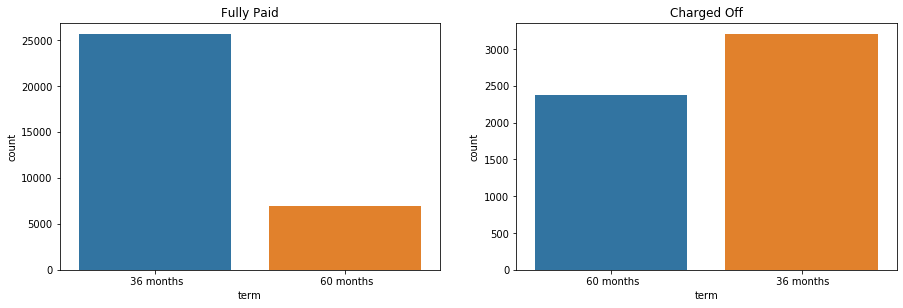

The ratio of default in different category of term are
 36 months    0.124932
 60 months    0.339820
Name: term, dtype: float64


In [63]:
plot_function_against_loan_status(column_name="term")
print("The ratio of default in different category of term are")
print(data[data["loan_status"]=="Charged Off"]["term"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["term"].value_counts()))
#longer loans are more chance to default

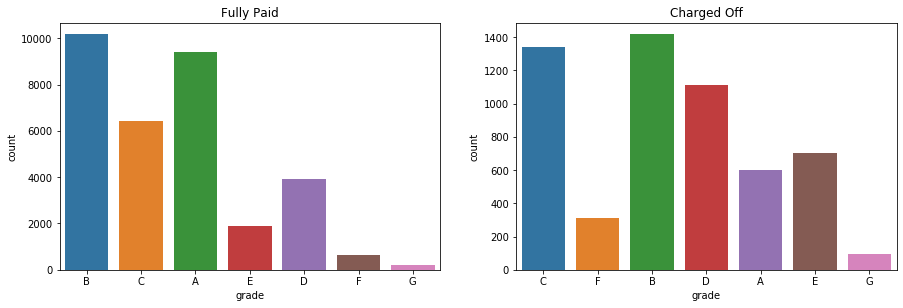

The ratio of default in different category of grade are
A    0.063977
B    0.139329
C    0.208958
D    0.284178
E    0.369474
F    0.481308
G    0.515789
Name: grade, dtype: float64


In [64]:
plot_function_against_loan_status(column_name="grade")
print("The ratio of default in different category of grade are")
print(data[data["loan_status"]=="Charged Off"]["grade"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["grade"].value_counts()))
#grade G has highest chance of default followed by F,E,D

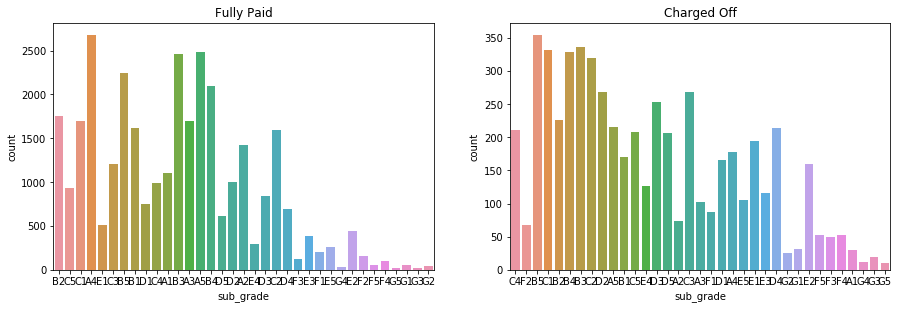

The ratio of default in different category of sub_grade are
A1    0.027125
A2    0.051893
A3    0.060660
A4    0.066344
A5    0.087062
B1    0.105133
B2    0.128775
B3    0.137048
B4    0.156863
B5    0.158411
C1    0.195870
C2    0.200251
C3    0.223608
C4    0.214213
C5    0.223176
D1    0.220159
D2    0.268731
D3    0.299882
D4    0.309696
D5    0.337684
E1    0.377907
E2    0.360544
E3    0.298969
E4    0.434483
E5    0.400000
F1    0.423077
F2    0.413580
F3    0.420168
F4    0.541667
F5    0.912281
G1    0.508197
G2    0.541667
G3    0.760000
G4    0.315789
G5    0.555556
Name: sub_grade, dtype: float64


In [65]:
plot_function_against_loan_status(column_name="sub_grade")
print("The ratio of default in different category of sub_grade are")
print(data[data["loan_status"]=="Charged Off"]["sub_grade"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["sub_grade"].value_counts()))
#subgrades of G has highest chance of default followed by F,E,D

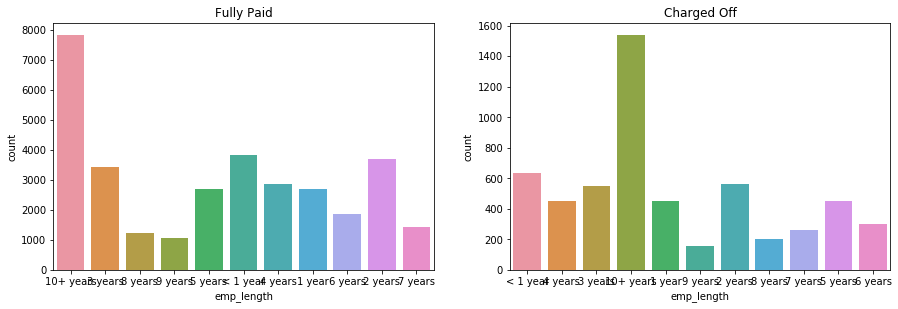

The ratio of default in different category of emp_length are
10+ years    0.196531
< 1 year     0.165841
2 years      0.152928
3 years      0.160631
4 years      0.158686
5 years      0.167404
1 year       0.168464
6 years      0.164139
7 years      0.182008
8 years      0.165982
9 years      0.148674
Name: emp_length, dtype: float64


In [66]:
plot_function_against_loan_status(column_name="emp_length")
print("The ratio of default in different category of emp_length are")
print(data[data["loan_status"]=="Charged Off"]["emp_length"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["emp_length"].value_counts()))
#There is no concrete conclusion wrt to emp_length

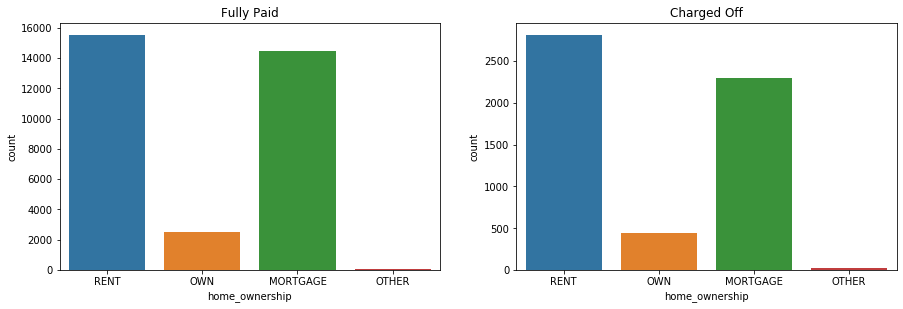

The ratio of default in different category of home_ownership are
RENT        0.181158
MORTGAGE    0.158961
OWN         0.175579
OTHER       0.230769
Name: home_ownership, dtype: float64


In [67]:
plot_function_against_loan_status(column_name="home_ownership")
print("The ratio of default in different category of home_ownership are")
print(data[data["loan_status"]=="Charged Off"]["home_ownership"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["home_ownership"].value_counts()))
#when house is on rent there is good chance of default but other two is also comparable

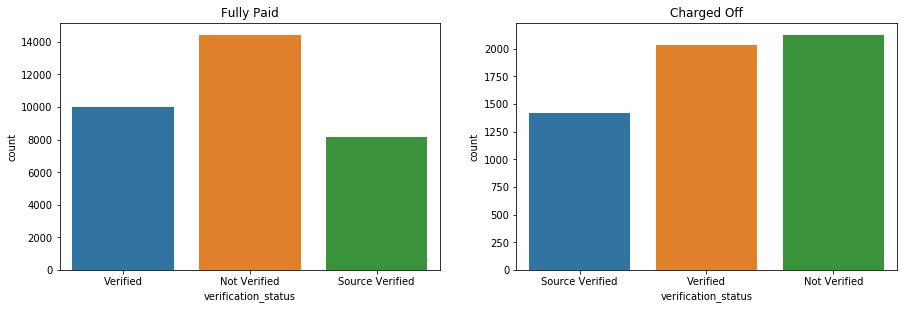

The ratio of default in different category of verification_status are
Not Verified       0.147177
Verified           0.202997
Source Verified    0.173934
Name: verification_status, dtype: float64


In [68]:
plot_function_against_loan_status(column_name="verification_status")
print("The ratio of default in different category of verification_status are")
print(data[data["loan_status"]=="Charged Off"]["verification_status"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["verification_status"].value_counts()))
#when verification_status is verified there is good chance of default but other two is also comparable

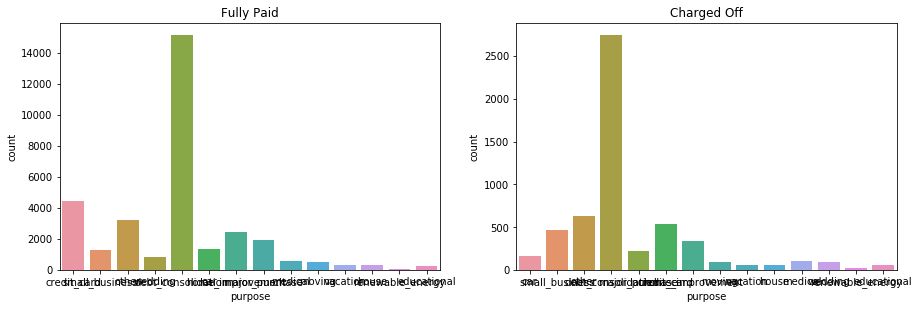

The ratio of default in different category of purpose are
car                   0.118175
credit_card           0.120872
debt_consolidation    0.181374
educational           0.209738
home_improvement      0.137693
house                 0.192691
major_purchase        0.115081
medical               0.185841
moving                0.190776
other                 0.195374
renewable_energy      0.222222
small_business        0.374106
vacation              0.165109
wedding               0.114914
Name: purpose, dtype: float64


In [69]:
plot_function_against_loan_status(column_name="purpose")
print("The ratio of default in different category of purpose are")
print(data[data["loan_status"]=="Charged Off"]["purpose"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["purpose"].value_counts()))
#small business ,educational and renenwal has high chances of default

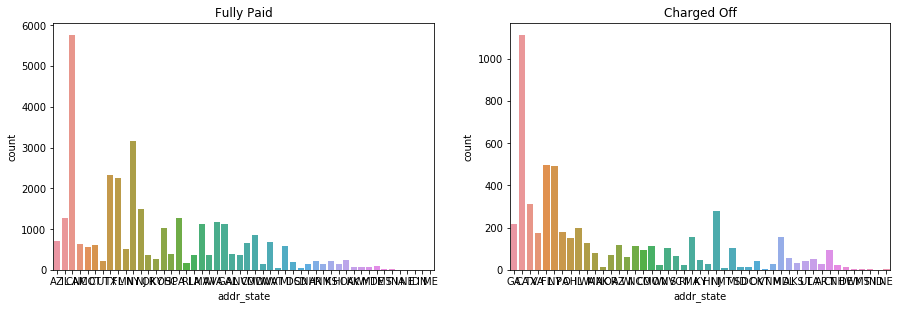

The ratio of default in different category of addr_state are
AK    0.222222
AL    0.142857
AR    0.129808
AZ    0.166898
CA    0.192967
CO    0.145675
CT    0.152597
DC    0.076531
DE    0.118812
FL    0.221039
GA    0.189594
HI    0.205882
IA         NaN
ID    0.200000
IL    0.155432
IN         NaN
KS    0.138393
KY    0.170455
LA    0.144809
MA    0.139161
MD    0.186321
ME         NaN
MI    0.170854
MN    0.155470
MO    0.206897
MS    0.117647
MT    0.152778
NC    0.179936
NE    1.500000
NH    0.179856
NJ    0.186156
NM    0.200000
NV    0.287263
NY    0.155063
OH    0.149166
OK    0.162602
OR    0.195055
PA    0.139171
RI    0.152439
SC    0.167526
SD    0.240000
TN    0.133333
TX    0.134483
UT    0.190476
VA    0.150127
VT    0.127660
WA    0.183673
WI    0.168901
WV    0.139073
WY    0.052632
Name: addr_state, dtype: float64


In [70]:
plot_function_against_loan_status(column_name="addr_state")
print("The ratio of default in different category of addr_state are")
print(data[data["loan_status"]=="Charged Off"]["addr_state"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["addr_state"].value_counts()))
#state with NV ,NE and FL has high chances of default

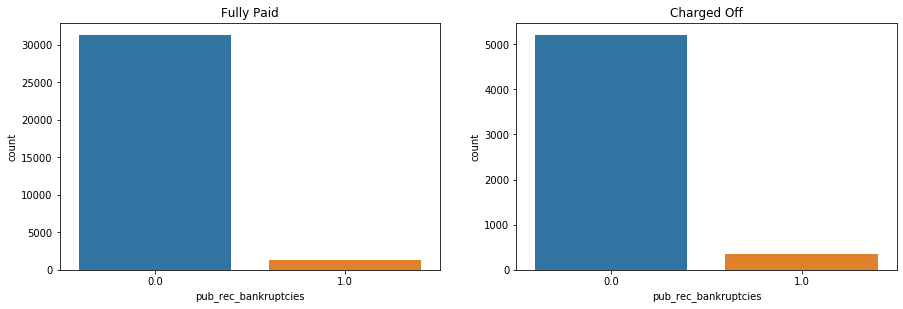

The ratio of default in different category of pub_rec_bankruptcies are
0.0    0.166379
1.0    0.285375
Name: pub_rec_bankruptcies, dtype: float64


In [71]:
plot_function_against_loan_status(column_name="pub_rec_bankruptcies")
print("The ratio of default in different category of pub_rec_bankruptcies are")
print(data[data["loan_status"]=="Charged Off"]["pub_rec_bankruptcies"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["pub_rec_bankruptcies"].value_counts()))
#when pub_rec_bankruptcies are 1 there is more chance of default compare to 0 

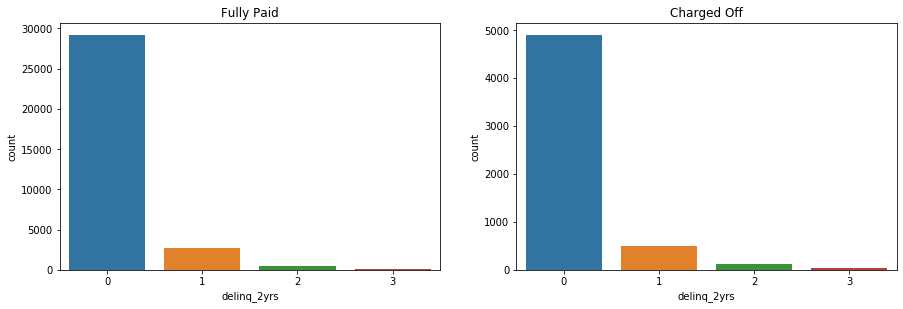

The ratio of default in different category of delinq_2yrs are
0    0.167881
1    0.188976
2    0.241573
3    0.202312
Name: delinq_2yrs, dtype: float64


In [72]:
plot_function_against_loan_status(column_name="delinq_2yrs")
print("The ratio of default in different category of delinq_2yrs are")
print(data[data["loan_status"]=="Charged Off"]["delinq_2yrs"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["delinq_2yrs"].value_counts()))
#when delinq_2yrs are 2 followed by 3 then 1

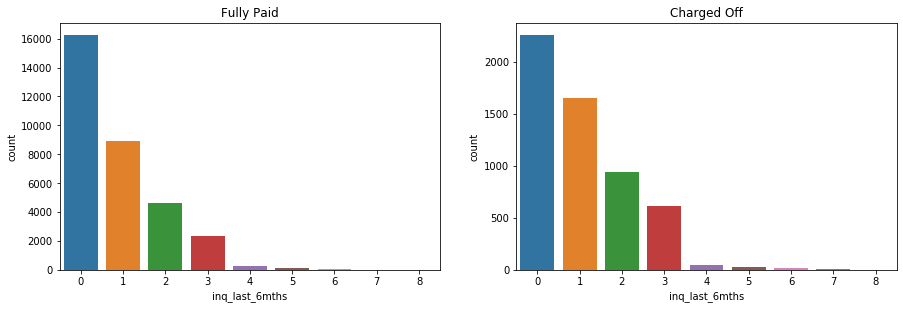

The ratio of default in different category of inq_last_6mths are
0    0.138839
1    0.186298
2    0.201847
3    0.263362
4    0.196911
5    0.236842
6    0.347826
7    0.434783
8    0.300000
Name: inq_last_6mths, dtype: float64


In [73]:
plot_function_against_loan_status(column_name="inq_last_6mths")
print("The ratio of default in different category of inq_last_6mths are")
print(data[data["loan_status"]=="Charged Off"]["inq_last_6mths"].value_counts()/(data[data["loan_status"]=="Fully Paid"]["inq_last_6mths"].value_counts()))
# if the inq_last_6mths is more than or equal to 5 then there is high chance of default

## Multivariate analysis

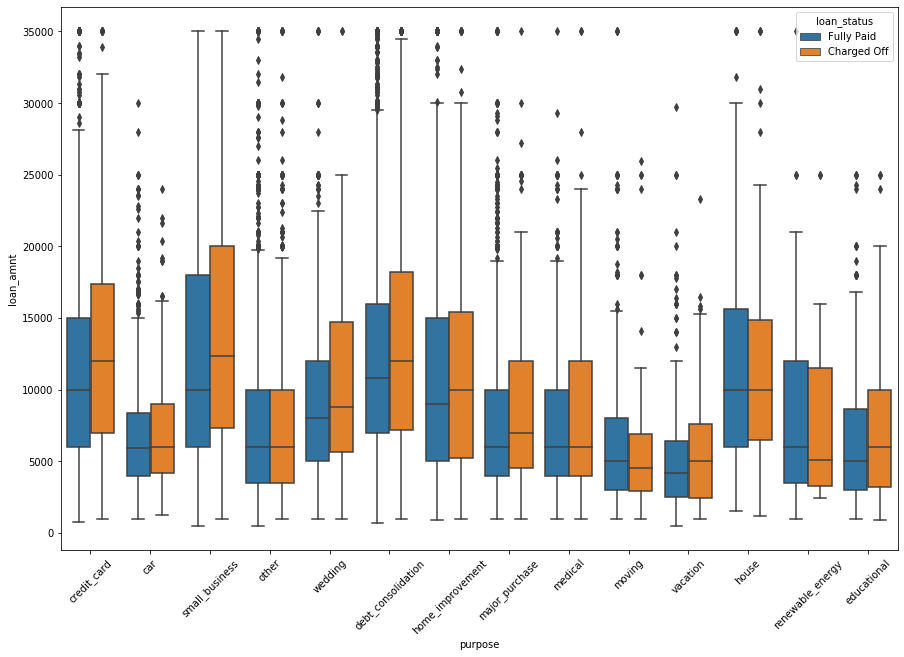

In [78]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(x = data['purpose'],y = data['loan_amnt'],hue = data['loan_status'])
#when the loan amount is high and purpose is credit card and small business then there is high chance of default

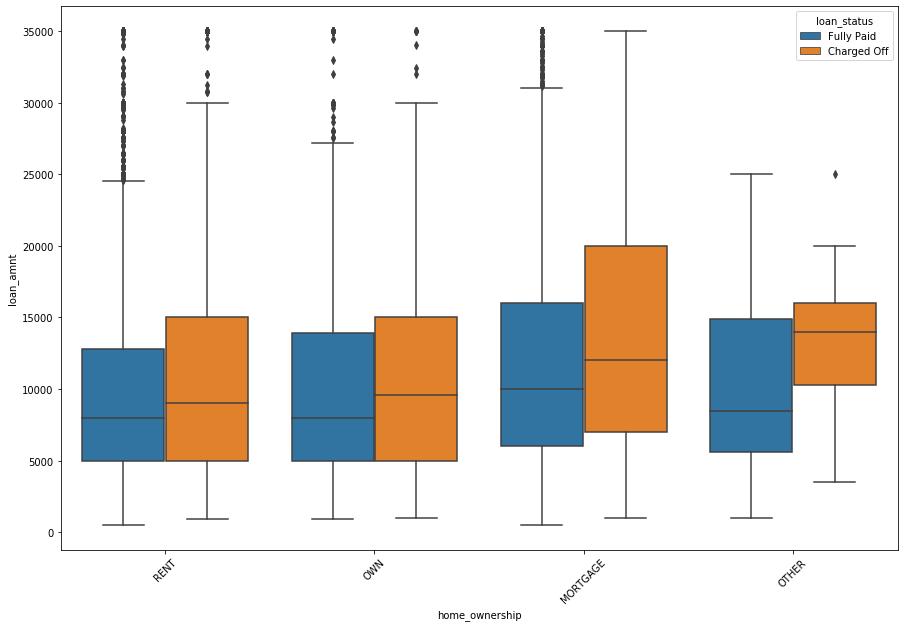

In [79]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(x = data['home_ownership'],y = data['loan_amnt'],hue = data['loan_status'])
# when the loan amount is greater than 15000 and home_ownership is mortgage then there is more chance of default

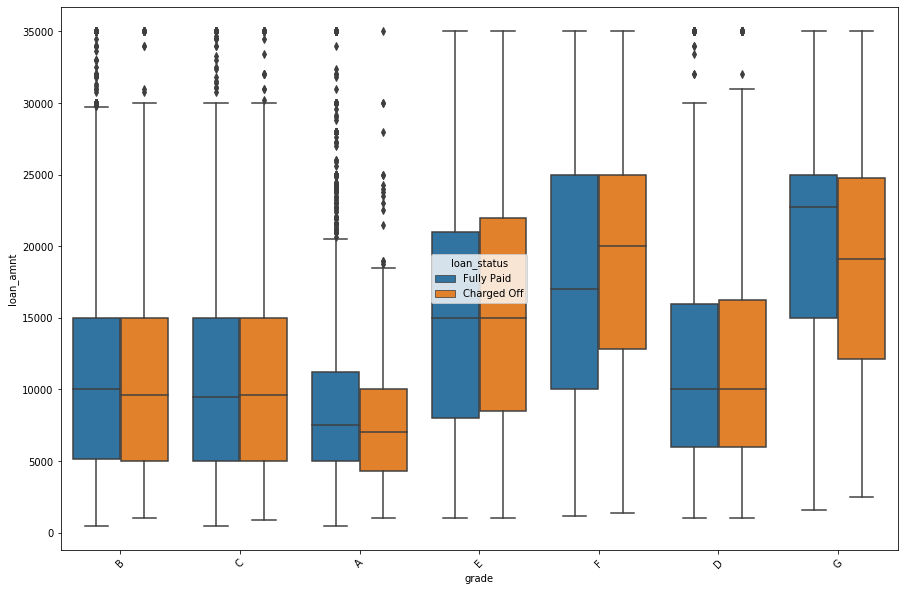

In [80]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(x = data['grade'],y = data['loan_amnt'],hue = data['loan_status'])
#when the loan amount is less than 15000 and subgrade is G then there is more chances of default

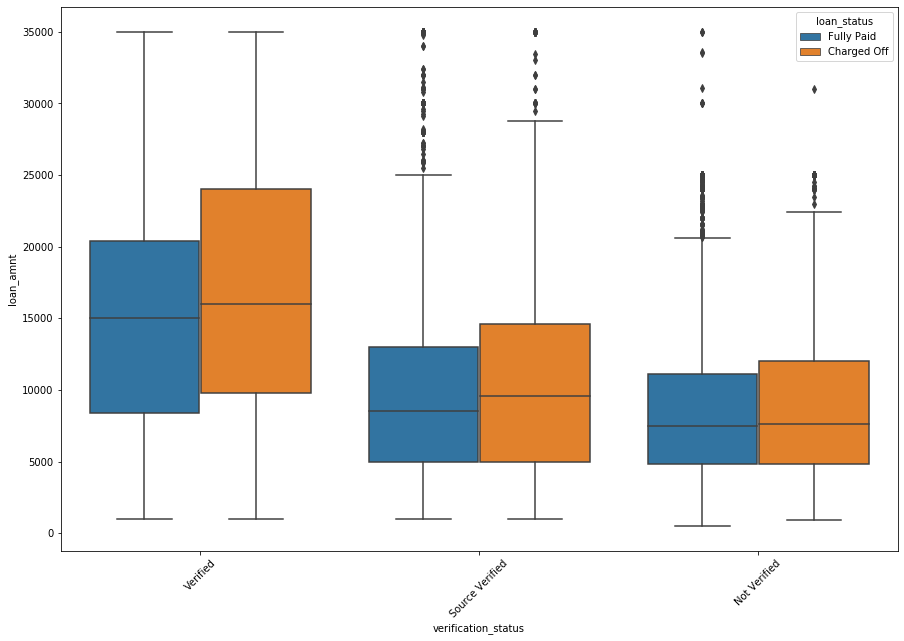

In [81]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(x = data['verification_status'],y = data['loan_amnt'],hue = data['loan_status'])
#when the loan amount is greater than 20000 and verification_status is verified then there is more chances of default

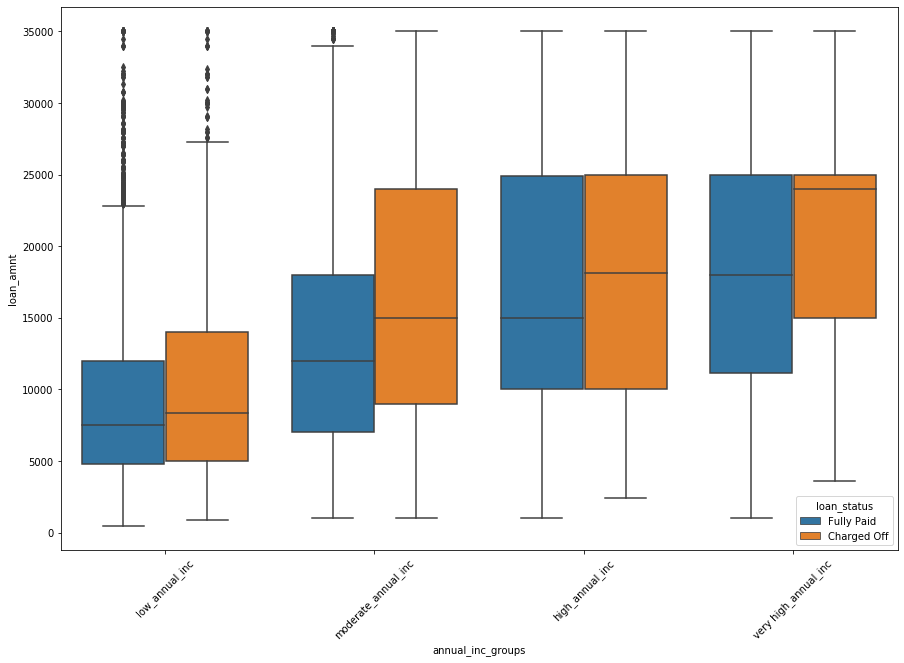

In [82]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(x = data['annual_inc_groups'],y = data['loan_amnt'],hue = data['loan_status'])
#when the loan amount is greater than 15000 and and annual_inc_groups is moderate annual income then there
# is high chance of default

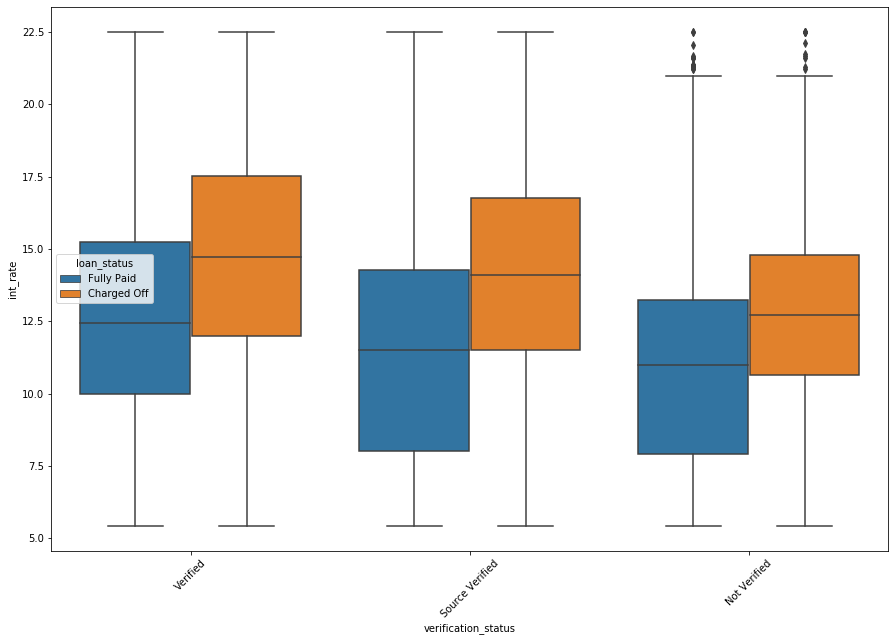

In [84]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(x = data['verification_status'],y = data['int_rate'],hue = data['loan_status'])
#with higher rate of interest irrespective of verification_status there is chance of default

In [85]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc',
       'pub_rec_bankruptcies', 'int_rate_groups', 'loan_amnt_groups',
       'installment_groups', 'annual_inc_groups', 'dti_groups',
       'revol_util_groups'],
      dtype='object')

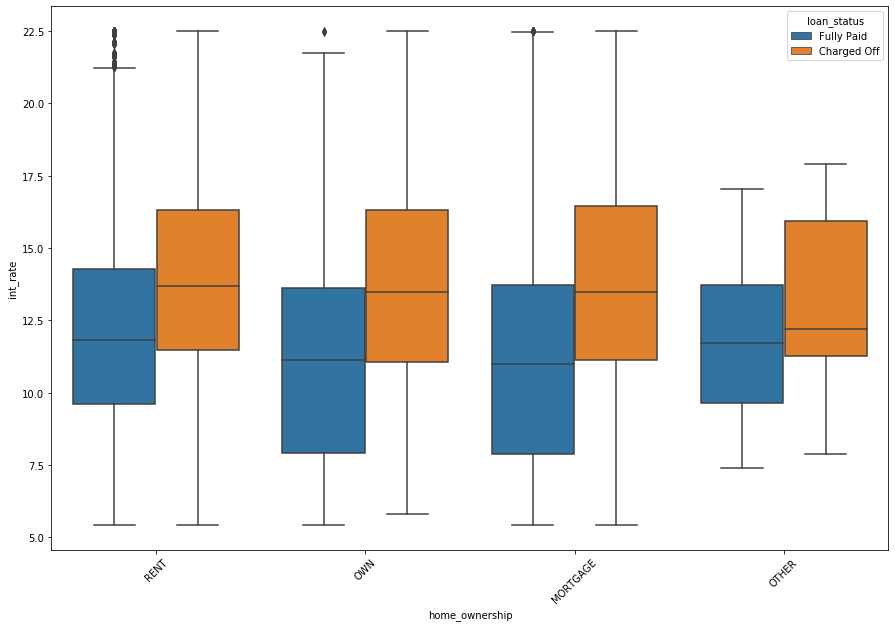

In [86]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(x = data['home_ownership'],y = data['int_rate'],hue = data['loan_status'])
#if the int rate is greater than 15 then there is chance of default irrespective of home_ownership

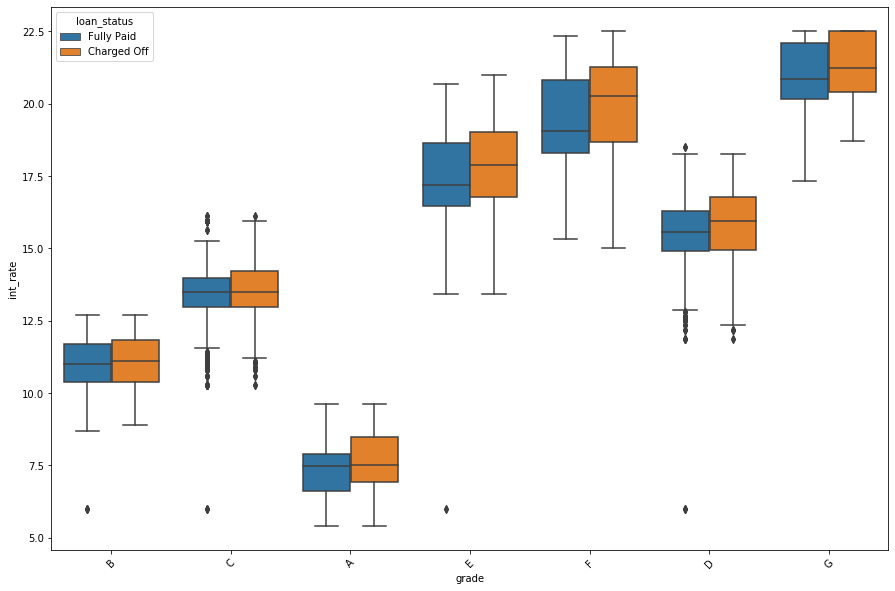

In [87]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(x = data['grade'],y = data['int_rate'],hue = data['loan_status'])
#if the int rate is higher then there is a chance of default when the grade is G ,F,E